# Introduction to gimVI
## Imputing missing genes in spatial data from sequencing data with gimVI

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import scanpy
import anndata
import numpy as np
import copy
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scvi.data import smfish, cortex
from scvi.external import GIMVI

train_size = 0.8

Global seed set to 0


In [3]:
spatial_data = smfish(run_setup_anndata=False)
seq_data = cortex(run_setup_anndata=False)

INFO     File                                                                                
         /data/yosef2/users/jhong/scvi-tutorials/data/osmFISH_SScortex_mouse_all_cell.loom   
         already downloaded                                                                  
INFO     Loading smFISH dataset                                                              
INFO     Downloading file at /data/yosef2/users/jhong/scvi-tutorials/data/expression.bin     
Downloading...: 121130it [00:02, 53483.10it/s]                              
INFO     Loading Cortex data from /data/yosef2/users/jhong/scvi-tutorials/data/expression.bin


/data/yosef2/users/jhong/miniconda3/envs/r_tutorial/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Finished loading Cortex data                                                        


## Preparing the data
In this section, we hold out some of the genes in the spatial dataset in order to test the imputation results

In [4]:
#only use genes in both datasets
seq_data = seq_data[:, spatial_data.var_names].copy()

seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes*train_size)

#randomly select training_genes
rand_train_gene_idx = np.random.choice(range(n_genes), n_train_genes, replace = False)
rand_test_gene_idx = sorted(set(range(n_genes)) - set(rand_train_gene_idx))
rand_train_genes = seq_gene_names[rand_train_gene_idx]
rand_test_genes = seq_gene_names[rand_test_gene_idx]

#spatial_data_partial has a subset of the genes to train on 
spatial_data_partial = spatial_data[:,rand_train_genes].copy()

#remove cells with no counts
scanpy.pp.filter_cells(spatial_data_partial, min_counts= 1)
scanpy.pp.filter_cells(seq_data, min_counts = 1)

#setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key='labels', batch_key='batch')
GIMVI.setup_anndata(seq_data, labels_key='labels')

#spatial_data should use the same cells as our training data
#cells may have been removed by scanpy.pp.filter_cells()
spatial_data = spatial_data[spatial_data_partial.obs_names]

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["labels"]                                               
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 4530 cells, 26 vars, 1 batches, 6 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["labels"]                                               
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 2

/data/yosef2/users/jhong/miniconda3/envs/r_tutorial/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Creating the model and training

In [5]:
#create our model
model = GIMVI(seq_data, spatial_data_partial)

#train for 200 epochs
model.train(200)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 200/200: 100%|██████████| 200/200 [04:30<00:00,  1.35s/it, loss=24.5, v_num=1]


## Analyzing the results

### Getting the latent representations and plotting UMAPs

In [6]:
#get the latent representations for the sequencing and spatial data
latent_seq, latent_spatial = model.get_latent_representation()

#concatenate to one latent representation
latent_representation = np.concatenate([latent_seq, latent_spatial])
latent_adata = anndata.AnnData(latent_representation)

#labels which cells were from the sequencing dataset and which were from the spatial dataset
latent_labels = (['seq'] * latent_seq.shape[0]) + (['spatial'] * latent_spatial.shape[0])
latent_adata.obs['labels'] = latent_labels

#compute umap
scanpy.pp.neighbors(latent_adata, use_rep = 'X')
scanpy.tl.umap(latent_adata)

#save umap representations to original seq and spatial_datasets
seq_data.obsm['X_umap'] = latent_adata.obsm['X_umap'][:seq_data.shape[0]]
spatial_data.obsm['X_umap'] = latent_adata.obsm['X_umap'][seq_data.shape[0]:]

... storing 'labels' as categorical


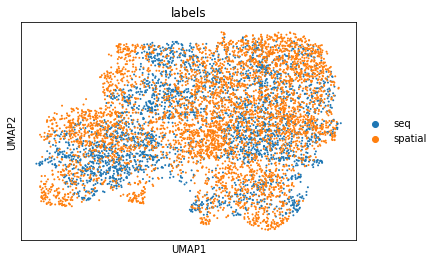

In [7]:
#umap of the combined latent space
scanpy.pl.umap(latent_adata, color = 'labels', show = True)

... storing 'precise_labels' as categorical
... storing 'cell_type' as categorical


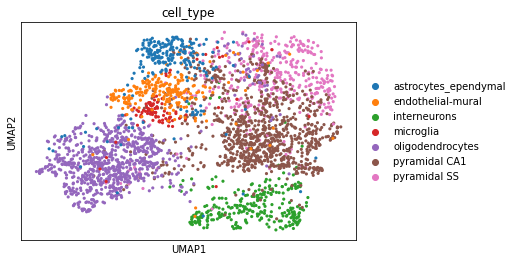

In [8]:
#umap of sequencing dataset
scanpy.pl.umap(seq_data, color = 'cell_type')

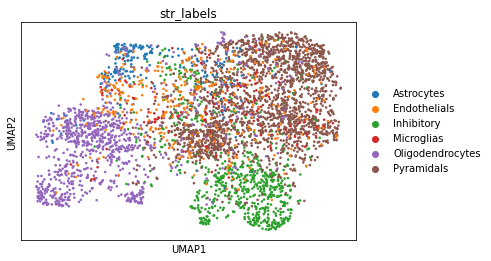

In [9]:
#umap of spatial dataset
scanpy.pl.umap(spatial_data, color = 'str_labels')

### Getting Imputation Score

imputation_score() returns the median spearman r correlation over all the cells

In [10]:
# utility function for scoring the imputation
def imputation_score(model, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = model.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original /= data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))

imputation_score(model, spatial_data, rand_test_gene_idx, True)

0.18796194200557673


### Plot imputation for *Lamp5*, which should have been hidden in the training

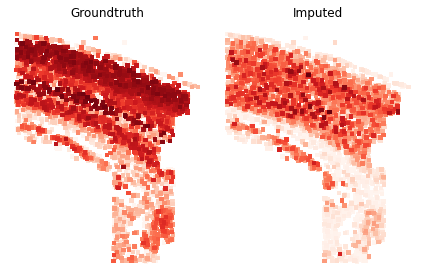

In [11]:
#utility function for plotting spatial genes
def plot_gene_spatial(model, data_spatial, gene):
    data_seq = model.adatas[0]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x_coord"]
    y_coord = data_fish.obs["y_coord"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = model.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

assert 'Lamp5' in rand_test_genes
plot_gene_spatial(model, spatial_data, 9)